In [ ]:
from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')

# --- FIND YOUR PATH ---
# You need to manually locate the exact path to 'AZT1D 2025.zip'
# inside your 'MyDrive' structure.

# Example: If you put it in a folder named 'My_Datasets':
DRIVE_FOLDER_PATH = '/content/drive/MyDrive/'
# If it's just in the root of your Drive:
# DRIVE_FOLDER_PATH = '/content/drive/MyDrive/'

ZIP_FILE_NAME = 'AZT1D 2025.zip'

FULL_ZIP_PATH = os.path.join(DRIVE_FOLDER_PATH, ZIP_FILE_NAME)
EXTRACTION_DIR = '/content/extracted_data'

print(f"Attempting to load from: {FULL_ZIP_PATH}")

Mounting Google Drive...
Mounted at /content/drive
Attempting to load from: /content/drive/MyDrive/AZT1D 2025.zip


In [ ]:
from google.colab import drive
import os

# Ensure the drive is mounted first (if it's not already)
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Drive already mounted.")

# 🚨 PASTE THE EXACT PATH YOU COPIED HERE! 🚨
# Example fix if you just put it in a folder named 'Colab Data' at the root of your Drive:
# FULL_ZIP_PATH = '/content/drive/MyDrive/Colab Data/AZT1D 2025.zip'

# If you can't find the path, try the root of your Drive first:
FULL_ZIP_PATH = '/content/drive/MyDrive/AZT1D 2025.zip'

# The name of the file
ZIP_FILE_NAME = 'AZT1D 2025.zip'

# We'll still extract to the fast, temporary storage
EXTRACTION_DIR = '/content/extracted_data'

print(f"Attempting to load from: {FULL_ZIP_PATH}")

Drive already mounted.
Attempting to load from: /content/drive/MyDrive/AZT1D 2025.zip


In [ ]:
import pandas as pd
import glob
import zipfile
import os

# --- Unzip the File ---
print(f"Extracting {ZIP_FILE_NAME} to {EXTRACTION_DIR}...")

os.makedirs(EXTRACTION_DIR, exist_ok=True)

try:
    with zipfile.ZipFile(FULL_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTION_DIR)
    print("✅ Extraction complete.")
except FileNotFoundError as e:
    print(f"❌ ERROR: ZIP file not found. Double-check your file path! Error: {e}")
    raise
except Exception as e:
    print(f"❌ ERROR during extraction: {e}")
    raise


# --- Combine All Subject Files ---
# Update the base data path to reflect the structure inside the zip file
# based on the user's clarification.
BASE_DATA_PATH = os.path.join(EXTRACTION_DIR, 'AZT1D 2025', 'CGM Records')
PATH_PATTERN = os.path.join(BASE_DATA_PATH, 'Subject *', '*.csv')

all_csv_files = glob.glob(PATH_PATTERN)

if all_csv_files:
    print(f"\n✅ Found {len(all_csv_files)} individual data files. Combining now...")

    list_of_dfs = []
    for file in all_csv_files:
      try:
        df_temp = pd.read_csv(file)
        list_of_dfs.append(df_temp)
      except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

    if list_of_dfs:
        df = pd.concat(list_of_dfs, ignore_index=True)

        print("\n--- Success! Combined Data Loaded into df ---")
        print(f"Final DataFrame Shape: {df.shape}")
        print(df.head())
    else:
        print("❌ ERROR: No dataframes were successfully loaded from the CSV files.")

else:
    print(f"❌ ERROR: No CSV files found using pattern: {PATH_PATTERN}. Check the extracted folder structure.")
    print(f"Expected pattern: {PATH_PATTERN}")
    # Optional: Add code here to list files/folders in EXTRACTION_DIR to help debugging
    # print("\nContents of extraction directory:")
    # !ls -R {EXTRACTION_DIR}

Extracting AZT1D 2025.zip to /content/extracted_data...
✅ Extraction complete.

✅ Found 25 individual data files. Combining now...

--- Success! Combined Data Loaded into df ---
Final DataFrame Shape: (306712, 10)
         EventDateTime DeviceMode BolusType  Basal  CorrectionDelivered  \
0  2024-01-13 00:02:23        NaN       NaN    NaN                  NaN   
1  2024-01-13 00:07:23        NaN       NaN    NaN                  NaN   
2  2024-01-13 00:12:23        NaN       NaN    NaN                  NaN   
3  2024-01-13 00:17:23        NaN       NaN    NaN                  NaN   
4  2024-01-13 00:22:23        NaN       NaN    NaN                  NaN   

   TotalBolusInsulinDelivered  FoodDelivered  CarbSize    CGM  \
0                         NaN            NaN       NaN  160.0   
1                         NaN            NaN       NaN  161.0   
2                         NaN            NaN       NaN  161.0   
3                         NaN            NaN       NaN  160.0   
4         

# **Data Cleaning and Time-Series Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# A. Initial Cleaning and Target Creation
df.dropna(subset=['CGM'], inplace=True)
df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])

# Target: 1 if glucose is high (>= 180 mg/dL), 0 otherwise
df['High_Glucose'] = np.where(df['CGM'] >= 180, 1, 0)

# Impute NaN in event columns with 0 (assuming NaN means 'no event')
imputation_cols = ['Basal', 'CorrectionDelivered', 'TotalBolusInsulinDelivered', 'FoodDelivered', 'CarbSize']
df[imputation_cols] = df[imputation_cols].fillna(0)

# Drop redundant/sparse column
df = df.drop(columns=['Readings (CGM / BGM)'])

# B. Time-Series Feature Engineering (CRITICAL for accuracy)
# Lag Features: Use .shift() to get previous CGM values
df['CGM_Lag1'] = df['CGM'].shift(1)
df['CGM_Lag2'] = df['CGM'].shift(2)

# Rate of Change (Velocity): Difference over the last 10 minutes
df['CGM_Delta'] = df['CGM_Lag1'] - df['CGM_Lag2']

# Drop the new NaNs created by the shift operation (first 2 rows of each subject's data)
df.dropna(subset=['CGM_Lag2', 'CGM_Delta'], inplace=True)
print(f"DataFrame shape after lag features and cleaning: {df.shape}")


# C. Categorical Feature Cleaning and Encoding
# Clean 'DeviceMode' and 'BolusType'
df['DeviceMode'] = df['DeviceMode'].replace({'0': 'Unknown', 'sleepsleep': 'sleep'}).fillna('Unknown')
df['BolusType'] = df['BolusType'].fillna('Unknown')
df['BolusType_Clean'] = df['BolusType'].apply(lambda x: x.split(' ')[0] if ' ' in str(x) and 'Extended' in str(x) else str(x))
df['BolusType_Clean'] = df['BolusType_Clean'].apply(lambda x: x.split('/')[0] if '/' in str(x) else str(x))
df['BolusType_Clean'] = df['BolusType_Clean'].replace({'0': 'Unknown', 'Extended': 'Extended Bolus', 'Standard': 'Standard Bolus', 'Quick': 'Quick Bolus'})

# Drop the original complex BolusType column
df = df.drop(columns=['BolusType'])

# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[['DeviceMode', 'BolusType_Clean']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['DeviceMode', 'BolusType_Clean']), index=df.index)

# Join and drop original categorical columns
df = pd.concat([df.drop(columns=['DeviceMode', 'BolusType_Clean']), encoded_df], axis=1)
print(f"Final feature count: {df.shape[1] - 3}") # -3 for CGM, High_Glucose, EventDateTime

DataFrame shape after lag features and cleaning: (293707, 13)
Final feature count: 17


# Step 1: Prepare Univariate Data (CGM Only, 5-Min Prediction)

In [ ]:
# (This cell replaces your previous "Multivariate Data Preparation" cell)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("--- Preparing Data with Feature Engineering for 5-minute Prediction ---")

# --- Define Parameters ---
SEQUENCE_LENGTH = 12      # Use 1-hour history
PREDICTION_HORIZON = 6       # Predict 30 mins ahead

# --- NEW: Feature Engineering ---
# We start from our cleaned dataframe 'df'
feat_df = df.copy().sort_values('EventDateTime')

# Find the time of the last non-zero event for carbs and bolus
feat_df['LastCarbTime'] = feat_df['EventDateTime'].where(feat_df['CarbSize'] > 0).ffill()
feat_df['LastBolusTime'] = feat_df['EventDateTime'].where(feat_df['TotalBolusInsulinDelivered'] > 0).ffill()

# Calculate the time difference in minutes
feat_df['TimeSinceCarb'] = (feat_df['EventDateTime'] - feat_df['LastCarbTime']).dt.total_seconds() / 60
feat_df['TimeSinceBolus'] = (feat_df['EventDateTime'] - feat_df['LastBolusTime']).dt.total_seconds() / 60

# Fill any initial NaN values (before the first event) with a large number
feat_df['TimeSinceCarb'].fillna(999, inplace=True)
feat_df['TimeSinceBolus'].fillna(999, inplace=True)


# --- Select our new, smarter feature set ---
feature_cols = ['CGM', 'CarbSize', 'TotalBolusInsulinDelivered', 'TimeSinceCarb', 'TimeSinceBolus']
target_col = 'CGM'

multi_df = feat_df[['EventDateTime'] + feature_cols].copy().dropna(subset=['CGM'])

# --- Sequence creation function (remains the same) ---
def create_sequences(data, sequence_length, prediction_horizon):
    X, y = [], []
    features = data[feature_cols].values
    target = data[target_col].values
    for i in range(len(data) - sequence_length - prediction_horizon + 1):
        X.append(features[i:(i + sequence_length)])
        y.append(target[i + sequence_length + prediction_horizon - 1])
    return np.array(X), np.array(y)

# --- Split and Scale (remains the same) ---
train_df, test_df = train_test_split(multi_df, test_size=0.3, shuffle=False)
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train_df[feature_cols] = feature_scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = feature_scaler.transform(test_df[feature_cols])
train_df[target_col] = target_scaler.fit_transform(train_df[[target_col]])
test_df[target_col] = target_scaler.transform(test_df[[target_col]])

# --- Create sequences ---
X_train, y_train = create_sequences(train_df, SEQUENCE_LENGTH, PREDICTION_HORIZON)
X_test, y_test = create_sequences(test_df, SEQUENCE_LENGTH, PREDICTION_HORIZON)

print("--- Data Preparation Complete ---")
print(f"Shape of training features (X_train): {X_train.shape}") # Should now have 5 features

--- Preparing Data with Feature Engineering for 5-minute Prediction ---


/tmp/ipython-input-1983425531.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat_df['TimeSinceCarb'].fillna(999, inplace=True)
/tmp/ipython-input-1983425531.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

--- Data Preparation Complete ---
Shape of training features (X_train): (205577, 12, 5)


# Step 2: Build the Transformer Model

In [ ]:
# (This cell replaces your previous "Build Model" cell)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Positional Embedding Layer ---
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        return inputs + self.position_embeddings(positions)

# --- Transformer Encoder Block ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    ff_output = layers.Dense(ff_dim, activation="relu")(x)
    ff_output = layers.Dense(inputs.shape[-1])(ff_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)
    return x

# --- Build the full model ---
def build_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    head_size = 128
    x = layers.Dense(head_size)(inputs)
    x = PositionalEmbedding(input_shape[0], head_size)(x)
    for _ in range(2):
        x = transformer_encoder(x, head_size=head_size, num_heads=4, ff_dim=64, dropout=0.2)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

# --- Instantiate the model with the new input shape ---
input_shape = X_train.shape[1:] # Will now be (12, 3)
model = build_model(input_shape)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 12, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 12, 128)   │        768 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 12, 128)   │      1,536 │ dense_35[0][0]    │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 128)   │    263,808 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 12, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 12, 128)   │          0 │ dropout_26[0][0], │
│                     │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 128)   │        256 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 12, 64)    │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 12, 128)   │      8,320 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 12, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 128)   │        256 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 12, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 12, 128)   │          0 │ dropout_28[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 128)   │        256 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 12, 64)    │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 12, 128)   │      8,320 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 12, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 564,993 (2.16 MB)

 Trainable params: 564,993 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

# Step 3: Compile and Train the Model

In [ ]:
# (This cell compiles and trains the model)

# Compile the model with a safe learning rate and appropriate loss function
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="mean_squared_error",
    metrics=["mean_absolute_error"] # This is our "accuracy" metric
)

# Callbacks to stop training when performance stalls and adjust the learning rate
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

print("\n--- Starting Model Training ---")
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100, # Will likely stop early
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)
print("\n--- Training Complete ---")


--- Starting Model Training ---
Epoch 1/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.9149 - mean_absolute_error: 0.7288 - val_loss: 0.7931 - val_mean_absolute_error: 0.6664 - learning_rate: 1.0000e-04
Epoch 2/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.8343 - mean_absolute_error: 0.6906 - val_loss: 0.7817 - val_mean_absolute_error: 0.6628 - learning_rate: 1.0000e-04
Epoch 3/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.8209 - mean_absolute_error: 0.6853 - val_loss: 0.7889 - val_mean_absolute_error: 0.6729 - learning_rate: 1.0000e-04
Epoch 4/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.8196 - mean_absolute_error: 0.6848 - val_loss: 0.7845 - val_mean_absolute_error: 0.6642 - learning_rate: 1.0000e-04
Epoch 5/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.8088 - mean_absolute_error: 0.6794 - val_loss: 0.7804 - val_mean_absolute_error: 0.6632 - learning_rate: 1.0000e-04
Epoch 6/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step 

# Step 4: Evaluate the Model and Check Accuracy


--- Evaluating Final Model on Test Data ---
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
✅ Final Test MAE (in mg/dL): 32.02 mg/dL
   (This is the average error in your model's 5-minute predictions)


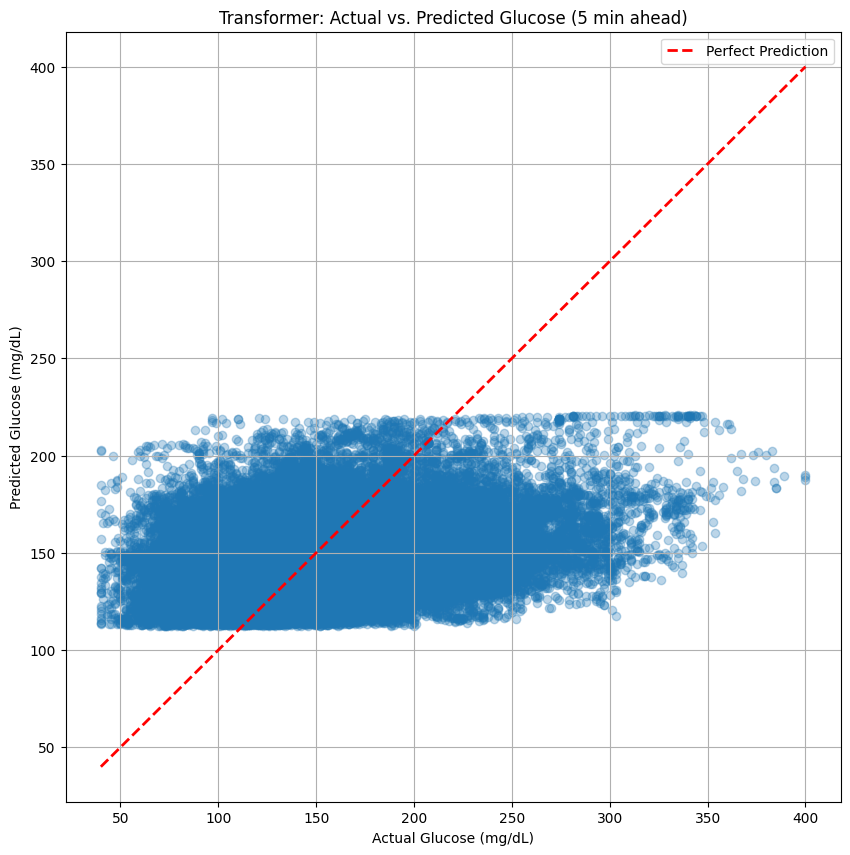

In [ ]:
# (This cell evaluates the final model and shows the plot)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

print("\n--- Evaluating Final Model on Test Data ---")

# --- Un-scale the predictions to make them interpretable ---
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Calculate and print the final "accuracy" (MAE) in mg/dL ---
final_mae = mean_absolute_error(y_test_actual, y_pred)
print(f"✅ Final Test MAE (in mg/dL): {final_mae:.2f} mg/dL")
print("   (This is the average error in your model's 5-minute predictions)")


# --- Plot Predictions vs. Actual Values ---
plt.figure(figsize=(10, 10))
plt.scatter(y_test_actual, y_pred, alpha=0.3)
plt.plot([min(y_test_actual.flatten()), max(y_test_actual.flatten())],
         [min(y_test_actual.flatten()), max(y_test_actual.flatten())],
         color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.title('Transformer: Actual vs. Predicted Glucose (5 min ahead)')
plt.xlabel('Actual Glucose (mg/dL)')
plt.ylabel('Predicted Glucose (mg/dL)')
plt.legend()
plt.grid(True)
plt.show()